In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cvxopt import matrix, solvers

# Reading the dataset

In [2]:
data = pd.read_csv("./dataset/Iris.csv")

In [3]:
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


# Checking for any null values

In [4]:
data.isnull().values.any()

False

# Plotting scatter plot to check if data are linearly seperable or not

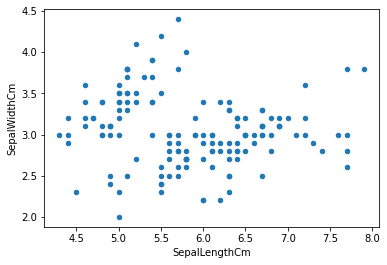

In [5]:
data.plot(kind="scatter", x="SepalLengthCm",   y="SepalWidthCm")
plt.show()

In [6]:
data.Species.unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

# Making the dataset linearly seperable

In [7]:
data = data[data.Species != "Iris-virginica"]

In [8]:
data["Species"].replace({"Iris-setosa": -1, "Iris-versicolor": 1}, inplace=True)

c:\users\pujag\appdata\local\programs\python\python39\lib\site-packages\pandas\core\generic.py:6610: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [9]:
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,-1
1,2,4.9,3.0,1.4,0.2,-1
2,3,4.7,3.2,1.3,0.2,-1
3,4,4.6,3.1,1.5,0.2,-1
4,5,5.0,3.6,1.4,0.2,-1


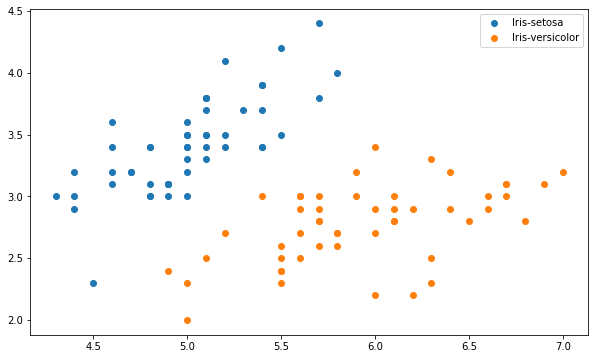

In [10]:
setosa = data.loc[data.Species == -1]
versicolor = data.loc[data.Species == 1]
set_1 = setosa.iloc[:, 1];
set_2 = setosa.iloc[:, 2];
vcolor_1 = versicolor.iloc[:, 1];
vcolor_2 = versicolor.iloc[:, 2];
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(set_1,set_2,label='Iris-setosa')
plt.scatter(vcolor_1,vcolor_2,label='Iris-versicolor')
plt.legend()
plt.show()

# Normalizing the data of feature columns between 0 to 1 and defining X and Y

In [11]:
Y = data.Species.values
X = data.drop(["Species","PetalLengthCm","PetalWidthCm","Id"], axis = 1)
X = (X - np.min(X))/(np.max(X)-np.min(X)).values
X.head()

,SepalLengthCm,SepalWidthCm
0,0.296296,0.625000
1,0.222222,0.416667
2,0.148148,0.500000
3,0.111111,0.458333
4,0.259259,0.666667


# Train & Test Split (70:30)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3,random_state=40)
print("features: ", X_train.shape)
print("labels: ", Y_train.shape)
print("test_features: ", X_test.shape)
print("test_labels: ", Y_test.shape)

features:  (70, 2)
labels:  (70,)
test_features:  (30, 2)
test_labels:  (30,)


# Implementing Soft SVM using  cvxopt_solvers

In [13]:
def linear_kernel_function(X, X1):
    return np.dot(X, X1.T)

In [14]:
C = 100
samples, features = X_train.shape
q = matrix(np.ones((samples, 1)) * -1)
A = matrix(Y_train.astype('float'), (1, samples), 'd')
b = matrix(np.zeros(1))    
G = matrix(np.vstack((np.eye(samples) * -1, np.eye(samples))))        
h = matrix(np.hstack((np.zeros(samples), np.ones(samples) * C)))
K = linear_kernel_function(X_train, X_train)
P = matrix(np.matmul(Y_train,Y_train.T) * K)

In [15]:
output = solvers.qp(P, q, G, h, A, b)
alpha = np.array(output['x'])
index = (alpha > 1e-4).flatten()
alpha = alpha[index]
sv_X = X_train[index]
sv_Y = Y_train[index]

     pcost       dcost       gap    pres   dres
 0: -1.0752e+02 -1.9171e+05  4e+05  3e-01  7e-13
 1:  2.2688e+02 -1.8826e+04  4e+04  3e-02  9e-13
 2:  2.9132e+02 -1.8233e+03  3e+03  1e-03  1e-13
 3:  9.2913e+01 -1.1293e+02  2e+02  1e-05  2e-14
 4:  1.3206e+01 -1.5851e+01  3e+01  2e-16  2e-14
 5:  1.7141e+00 -2.4532e+00  4e+00  2e-16  9e-15
 6:  1.5876e-01 -4.3218e-01  6e-01  2e-16  4e-15
 7:  1.3914e-02 -3.9609e-01  4e-01  3e-16  3e-15
 8: -1.8698e-01 -2.8440e-01  1e-01  2e-16  1e-15
 9: -2.2328e-01 -2.2668e-01  3e-03  2e-16  1e-15
10: -2.2541e-01 -2.2545e-01  4e-05  2e-16  1e-15
11: -2.2544e-01 -2.2544e-01  4e-07  2e-16  1e-15
12: -2.2544e-01 -2.2544e-01  4e-09  2e-16  1e-15
Optimal solution found.


In [16]:
alpha

array([[0.22544031],
       [0.22544031]])

In [17]:
bias = sv_Y - np.sum(linear_kernel_function(sv_X, sv_X) * alpha * sv_Y, axis=0)
bias = np.sum(bias) / bias.size

In [18]:
weights = np.zeros(features)
sv_X=sv_X.values
for i in range(len(alpha)):
    weights += alpha[i] * sv_Y[i] * sv_X[i]

In [19]:
weights

array([ 0.04174821, -0.02818004])

In [20]:
bias

-0.00519678179661387

In [21]:
def predict(X,w):
    l_output =np.sign(np.dot(X, w)+bias) 
    return l_output

In [22]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

# Predicting the accuracy of train data

In [23]:
y_predict_train = predict(X_train,weights)

In [24]:
print("Train accuracy: ", accuracy(Y_train, y_predict_train)) 

Train accuracy:  0.9857142857142858


# Predicting the accuracy of test data

In [25]:
y_predict_test = predict(X_test,weights)

In [26]:
print("Test accuracy: ", accuracy(Y_test, y_predict_test)) 

Test accuracy:  1.0
